# Курсовой проект для курса "Python для Data Science"

## Info

Материалы к проекту (файлы):
train.csv
test.csv

Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Основная метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Вспомогательная метрика:
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

Сдача проекта:
1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

Сроки сдачи:
Сдать проект за 72 часа до начала Урока 13 ("Вебинар. Результаты итоговых проектов и закрытие курса").

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

## Загрузка данных


### Импорт пакетов

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy import stats


# %matplotlib inline
# %config InlineBackend.figure_format = 'svg'

### Функции

In [30]:
def optimizing_df(df):
    for col in df.columns:
        if df[col].dtypes.kind == 'i' or df[col].dtypes.kind == 'u':
            if df[col].min() >= 0:
                df[col] = pd.to_numeric(df[col], downcast='unsigned')
            else:
                df[col] = pd.to_numeric(df[col], downcast='integer')

        elif df[col].dtypes.kind == 'f' or df[col].dtypes.kind == 'c':
            df[col] = pd.to_numeric(df[col], downcast='float')

        elif df[col].dtypes.kind == 'O':
            num_unique_values = len(df[col].unique())
            num_total_values = len(df[col])
            if num_unique_values / num_total_values < 0.5:
                df[col] = df[col].astype('category')

    return df

### Загружаем данные

In [31]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Data is loaded!")

Data is loaded!


In [32]:
print(f"Train:\t{train.shape[0]}\t sales and {train.shape[1]} features")
print(f'Test:\t{test.shape[0]}\t sales and {test.shape[1]} features')

Train:	10000	 sales and 20 features
Test:	5000	 sales and 19 features


In [33]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [34]:
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [35]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [36]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

### Оптмизация памяти

In [37]:
train['Rooms'] = train['Rooms'].astype('int64')
test['Rooms'] = test['Rooms'].astype('int64')

In [38]:
train = optimizing_df(train)
test = optimizing_df(test)

In [39]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  uint16  
 1   DistrictId     10000 non-null  uint8   
 2   Rooms          10000 non-null  uint8   
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  uint8   
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  uint32  
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  uint8   
 13  Social_2       10000 non-null  uint16  
 14  Social_3       10000 non-null  uint8   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  uint8   
 17  Shops_1        10000 non-null  u

In [40]:
test.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   uint16  
 1   DistrictId     5000 non-null   uint8   
 2   Rooms          5000 non-null   uint8   
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   uint8   
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   uint16  
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   uint8   
 13  Social_2       5000 non-null   uint16  
 14  Social_3       5000 non-null   uint8   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   uint8   
 17  Shops_1        5000 non-null   ui

### Проверка 

In [41]:
all_data = pd.concat((train, test), sort=False).reset_index(drop=True)
all_data.drop(['Price'], axis=1, inplace=True)
print(f'all_data size is : {all_data.shape}')

all_data size is : (15000, 19)


In [42]:
all_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,15000.0,8393.136933,4850.111673,0.000000,4188.750000,8378.500000,12594.250000,1.679800e+04
DistrictId,15000.0,50.693600,43.786257,0.000000,20.000000,37.000000,75.000000,2.120000e+02
Rooms,15000.0,1.897000,0.839229,0.000000,1.000000,2.000000,2.000000,1.900000e+01
Square,15000.0,56.360352,20.423912,1.136859,41.814370,52.645758,66.036606,6.410652e+02
LifeSquare,11846.0,36.851791,71.120186,0.333490,22.896130,32.822811,45.144627,7.480592e+03
KitchenSquare,15000.0,6.174467,24.016979,0.000000,1.000000,6.000000,9.000000,2.014000e+03
Floor,15000.0,8.561800,5.323113,1.000000,4.000000,7.000000,12.000000,7.800000e+01
HouseFloor,15000.0,12.606600,6.780165,0.000000,9.000000,12.000000,17.000000,1.170000e+02
HouseYear,15000.0,3321.575067,163707.780381,1908.000000,1974.000000,1977.000000,2001.000000,2.005201e+07
Ecology_1,15000.0,0.119196,0.119371,0.000000,0.017647,0.075424,0.195781,5.218670e-01


#### комнаты

In [43]:
all_data.loc[all_data['Rooms'] > 6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
377,5927,57,10,59.056976,36.223072,10.0,22,22.0,2002,0.090799,B,B,74,19083,2,NaN,5,15,B
1454,8491,1,19,42.006046,21.779287,7.0,17,17.0,2014,0.007122,B,B,1,264,0,NaN,0,1,B
8849,14865,9,10,60.871265,38.420681,10.0,3,2.0,1994,0.161532,B,B,25,5648,1,30.0,2,4,B
13398,1435,111,17,52.866108,32.528343,8.0,15,17.0,1987,0.093443,B,B,23,4635,5,3300.0,2,4,B


In [44]:
all_data.loc[all_data['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1397,12638,27,0,138.427689,136.215500,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B
1981,7917,27,0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B
2269,7317,27,0,41.790882,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3911,770,28,0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B
4366,456,6,0,81.491447,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B
4853,3224,27,0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B
6149,3159,88,0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B
8834,9443,27,0,87.762619,85.125473,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
12406,3343,58,0,116.824203,113.692421,0.0,3,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
12524,10729,27,0,76.345154,42.820797,12.0,14,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B


In [45]:
def df_fix_room(df):
    info_by_district_id = df.groupby(['DistrictId', 'HouseYear'], as_index=False).agg(
        {'Rooms': 'sum', 'Square': 'sum'}).rename(
        columns={'Rooms': 'sum_roos_dr', 'Square': 'sum_square_dr'})

    info_by_district_id['mean_square_per_room_in_dr'] = info_by_district_id['sum_square_dr'] \
        / info_by_district_id['sum_roos_dr']
    info_by_district_id.drop(
        ['sum_square_dr', 'sum_roos_dr'], axis=1, inplace=True)

    df = pd.merge(df, info_by_district_id, on=[
                  'DistrictId', 'HouseYear'], how='left')

    df['mean_square_per_room_in_dr'] = df['mean_square_per_room_in_dr'].fillna(
        df['mean_square_per_room_in_dr'].mean())

    df.loc[df['Rooms'] > 6, 'Rooms'] \
        = (df.loc[df['Rooms'] > 6, 'Square']
           // df.loc[df['Rooms'] > 6, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] \
        = (df.loc[df['Rooms'] == 0, 'Square']
           // df.loc[df['Rooms'] == 0, 'mean_square_per_room_in_dr']).astype('int')

    df.loc[df['Rooms'] == 0, 'Rooms'] = 1
    return df

#### площадь

In [46]:
all_data.loc[all_data['Square'] > 200].nlargest(20, 'Square')

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
6977,11602,30,2,641.065186,638.163208,10.0,20,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B
4262,28,9,2,604.705994,NaN,1.0,17,18.0,1977,0.161532,B,B,25,5648,1,30.0,2,4,B
4690,2307,102,1,409.425171,410.639740,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B
1982,5548,86,5,275.645294,233.949310,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B
13217,4058,27,6,223.453690,104.113556,16.0,2,2.0,2017,0.041116,B,B,53,14892,4,NaN,1,4,B
13909,1397,76,3,221.138763,118.055344,4.0,32,48.0,2011,0.000000,B,B,7,1660,39,1786.0,1,5,B
1981,7917,27,0,212.932358,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B
9910,16568,27,4,200.334534,201.627365,25.0,1,2.0,2013,0.041116,B,B,53,14892,4,NaN,1,4,B


C:\Users\maxro\AppData\Local\Temp\ipykernel_19140\2057381852.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_data['Square'], fit=norm)


mu = 56.36 and sigma = 20.42


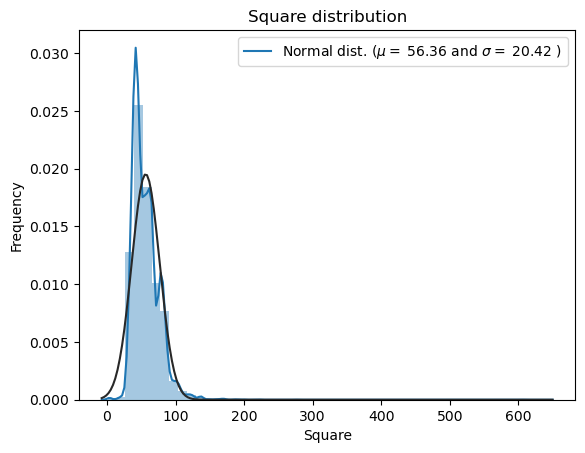

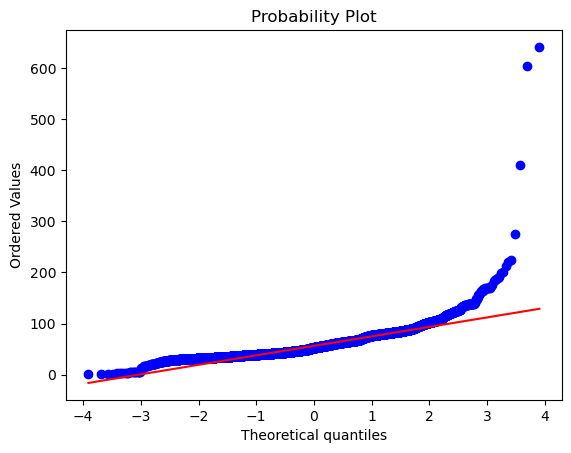

In [48]:
sns.distplot(all_data['Square'], fit=norm)

mu, sigma = norm.fit(all_data['Square'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'])
plt.ylabel('Frequency')
plt.title('Square distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(all_data['Square'], plot=plt)
plt.show()

In [49]:
def df_fix_square_manual(df):
    df.loc[df['Square'] > 400, 'Square'] = df.loc[df['Square'] > 400, 'Square'] / 10
    return df

In [50]:
def df_fix_square(df):
    info_by_district_id = df.groupby(['DistrictId', 'Rooms', 'HouseYear'], as_index=False).agg(
        {'Square': 'mean'}).rename(
        columns={'Square': 'mean_square_rooms_dr'})

    df = pd.merge(df, info_by_district_id, on=[
        'DistrictId', 'Rooms', 'HouseYear'], how='left')

    df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Square'] \
        = df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'Rooms'] \
        * df.loc[abs(df['Square'] - df['mean_square_rooms_dr']) > 2 * sigma, 'mean_square_per_room_in_dr']
    return df

In [51]:
def prepare_lifesquare(df):
    df.loc[df['Square'] < df['LifeSquare'],
           'LifeSquare'] = df.loc[df['Square'] < df['LifeSquare'], 'Square']
    return df


def fillna_life_square(df):
    df['LifeSquare'] = df['LifeSquare'].fillna(df['LifeSquare'].mean())
    return df

#### дата постройки

In [52]:
all_data.loc[all_data['HouseYear'] > 2020]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
1497,10814,109,1,37.265072,20.239714,9.0,9,12.0,20052011,0.136330,B,B,30,6141,10,262.0,3,6,B
4189,11607,147,2,44.791836,28.360394,5.0,4,9.0,4968,0.319809,B,B,25,4756,16,2857.0,5,8,B


In [53]:
def df_fix_house_year_manual(df):
    df.loc[df['HouseYear'] == 20052011, 'HouseYear'] = int((2005 + 2011) / 2)
    df.loc[df['HouseYear'] == 4968, 'HouseYear'] = 1968
    return df

## Работа с данными

### Загружаем пакеты

In [54]:
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

### Целевая переменная¶

#### Нормальное распределение целевой переменной

C:\Users\maxro\AppData\Local\Temp\ipykernel_19140\3952579941.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['Price'], fit=norm)


mu = 214138.86 and sigma = 92867.65


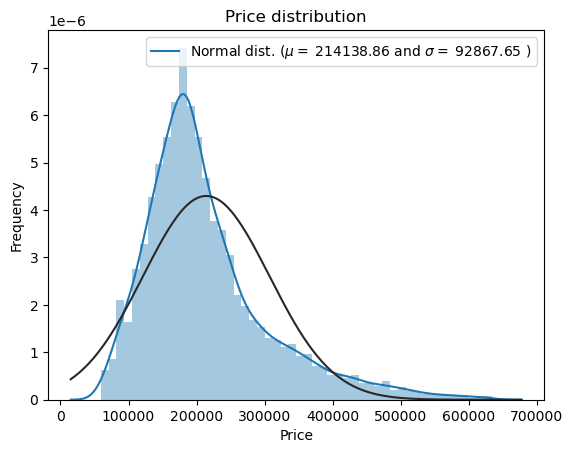

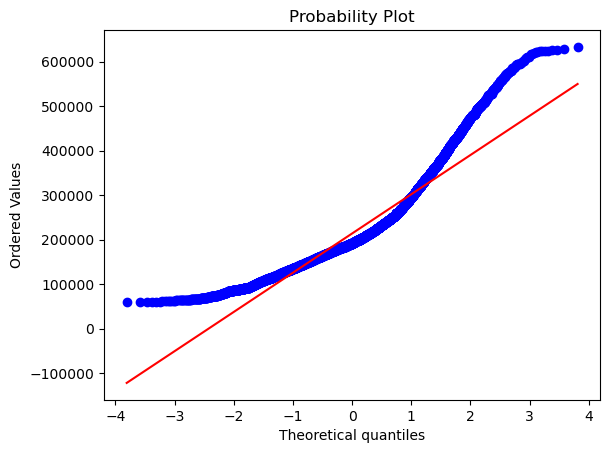

In [55]:
sns.distplot(train['Price'], fit=norm)

mu, sigma = norm.fit(train['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(train['Price'], plot=plt)
plt.show()

#### Логарифмическое для целевой переменной

C:\Users\maxro\AppData\Local\Temp\ipykernel_19140\128968211.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(price_log, fit=norm)


mu = 214138.86 and sigma = 92867.65


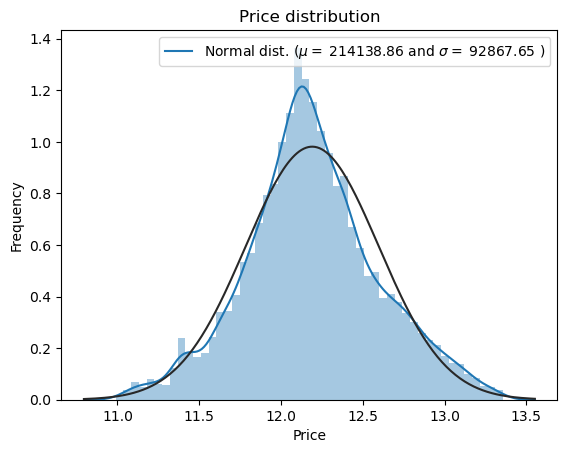

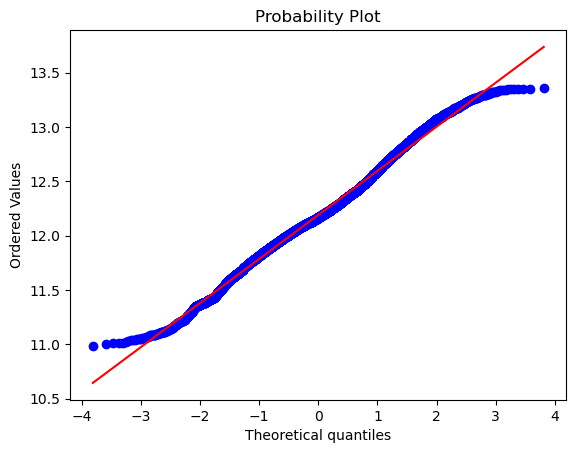

In [56]:
price_log = np.log1p(train['Price'])
sns.distplot(price_log, fit=norm)

mu, sigma = norm.fit(train['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.show()

### Недостающие данные

In [59]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(
    all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': all_data_na})
missing_data

,Missing Ratio
Healthcare_1,47.833333
LifeSquare,21.026667


In [60]:
def df_del_missing(df):
    df_na = (df.isnull().sum() / len(df)) * 100

    df_na = df_na.drop(
        df_na[df_na == 0].index).sort_values(ascending=False)
    df_na = list(df_na.index)
    df.drop(df_na, axis=1, inplace=True)
    return df

#### Коррекция данных

C:\Users\maxro\AppData\Local\Temp\ipykernel_19140\664460429.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = train.loc[:, train.columns != 'Id'].corr()


<AxesSubplot: >

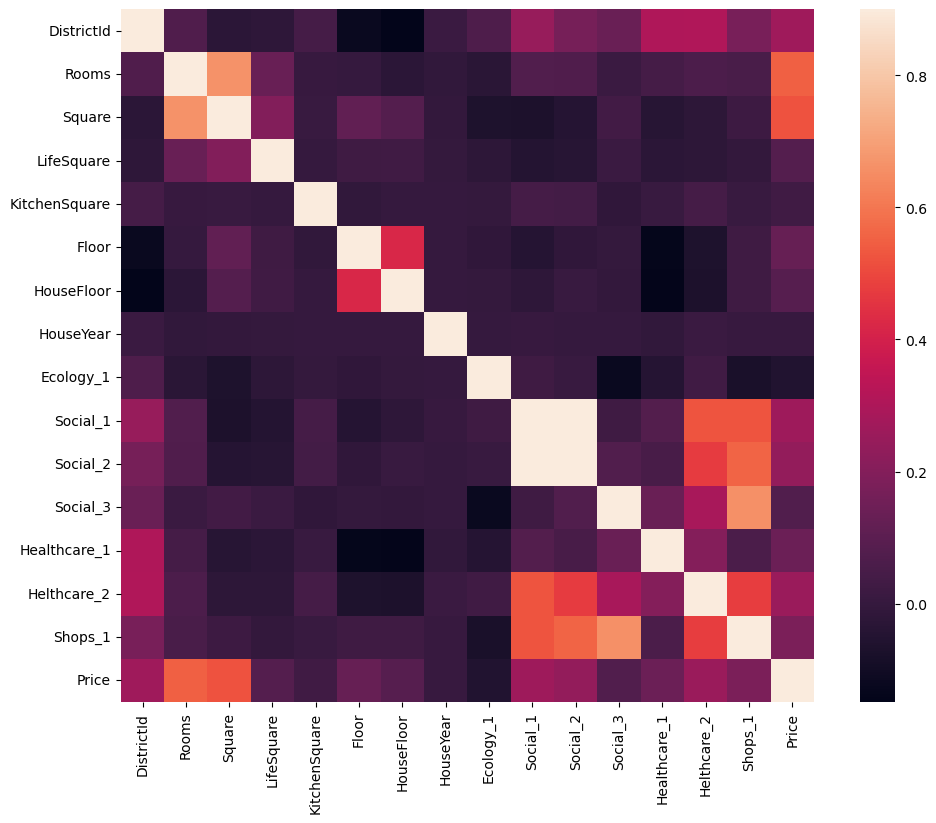

In [61]:
corrmat = train.loc[:, train.columns != 'Id'].corr()
plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=0.9, square=True)

C:\Users\maxro\AppData\Local\Temp\ipykernel_19140\389518036.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = train.loc[:, train.columns != 'Id'].corrwith(


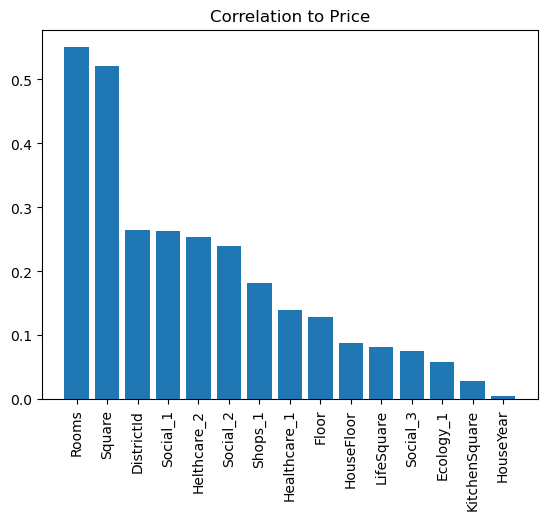

In [62]:
corrmat = train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Correlation to Price')
plt.xticks(rotation='vertical')
plt.show()

In [63]:
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2,47.981560,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3,65.683640,40.049541,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2,53.352982,52.731510,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1,39.649193,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


#### Кластер

In [64]:
scaler = MinMaxScaler()

In [65]:
train_cluster = train.copy()

In [66]:
train_cluster = df_fix_house_year_manual(train_cluster)

In [67]:
train_cluster_scaled = pd.DataFrame(scaler.fit_transform(
    train_cluster.loc[:, ['HouseYear', 'Price']]), columns=['HouseYear', 'Price'])

C:\anaconda3\envs\DS\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\anaconda3\envs\DS\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\anaconda3\envs\DS\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\anaconda3\envs\DS\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\anaconda3\envs\DS\lib\site-packages\sklearn\cluster\_kmeans.py:870: F

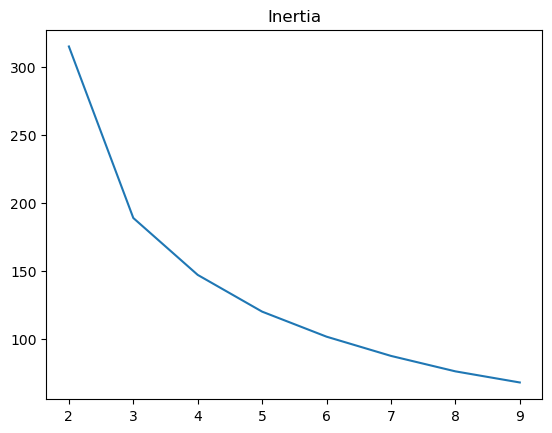

In [68]:
inertias = []

for i in range(2, 10):
    temp_model = KMeans(n_clusters=i, random_state=100)
    temp_model.fit(train_cluster_scaled)
    temp_inertia = temp_model.inertia_
    inertias.append(temp_inertia)

plt.plot(range(2, 10), inertias)
plt.title('Inertia')

plt.show()

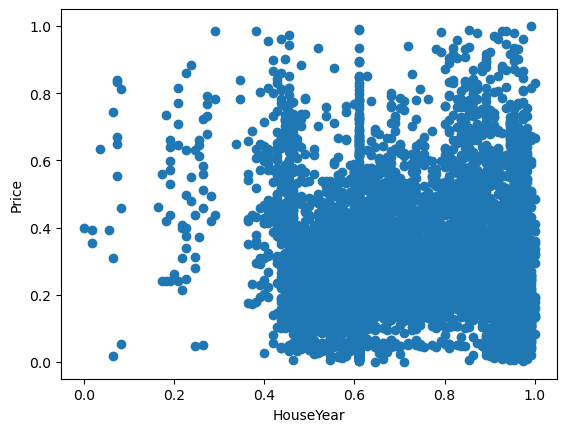

In [69]:
plt.scatter(train_cluster_scaled['HouseYear'], train_cluster_scaled['Price'])
plt.xlabel('HouseYear')
plt.ylabel('Price')
plt.show()

In [70]:
kmeans_model = KMeans(n_clusters=5, random_state=100)

In [71]:
train_labels = kmeans_model.fit_predict(train_cluster_scaled)

C:\anaconda3\envs\DS\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0.5, 1.0, 'Train data')

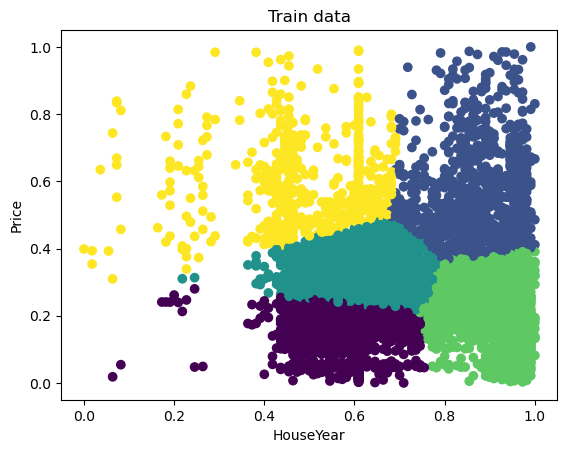

In [72]:
plt.scatter(train_cluster_scaled['HouseYear'],
            train_cluster_scaled['Price'], c=train_labels)

plt.xlabel('HouseYear')
plt.ylabel('Price')

plt.title('Train data')

In [73]:
agglomerative_clustering_model = AgglomerativeClustering(n_clusters=5)

In [74]:
train_cluster['cluster_year'] = agglomerative_clustering_model.fit_predict(
    train_cluster_scaled)

Text(0.5, 1.0, 'Train')

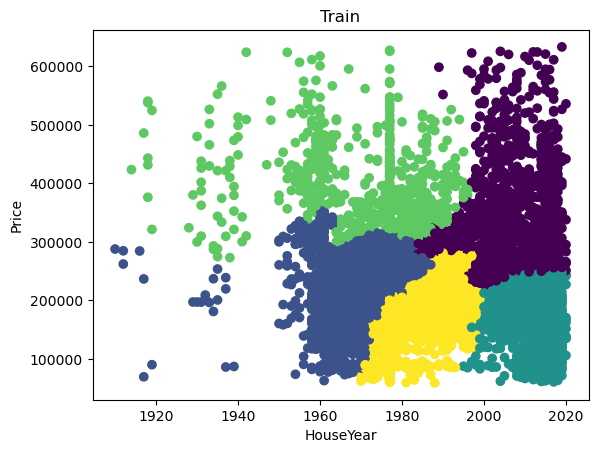

In [75]:
plt.scatter(train_cluster['HouseYear'],
            train_cluster['Price'], c=train_cluster['cluster_year'])
plt.xlabel('HouseYear')
plt.ylabel('Price')
plt.title('Train')

In [76]:
def add_cluster_year(df):
    df_scaled = pd.DataFrame(scaler.fit_transform(
        df.loc[:, ['HouseYear']]), columns=['HouseYear'])
    df['cluster_year'] = agglomerative_clustering_model.fit_predict(df_scaled)
    return df

#### Средняя цена комнат и средняя по районам

In [77]:
def add_mean_price(df, df_train=train):
    price = df_train['Price'].mean()
    price_mean_by_rooms = df_train.groupby(['Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_by_rooms'})

    price_mean_by_distr_rooms = df_train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'mean'}).\
        rename(columns={'Price': 'mean_price_dr'})

    df = pd.merge(df, price_mean_by_distr_rooms, on=[
                  'DistrictId', 'Rooms'], how='left')
    df = pd.merge(df, price_mean_by_rooms, on='Rooms', how='left')
    df['mean_price_dr'] = df['mean_price_dr'].fillna(df['mean_price_by_rooms'])
    df['mean_price_dr'] = df['mean_price_dr'].fillna(price)
    df['mean_price_by_rooms'] = df['mean_price_by_rooms'].fillna(price)
    return df

#### Большой район

In [78]:
def add_distr_info(df):
    distr_info = df['DistrictId'].value_counts().reset_index().\
        rename(columns={"index": "DistrictId", "DistrictId": 'large_district'})
    df = pd.merge(df, distr_info, on='DistrictId', how='left')
    df['large_district'] = df['large_district'].fillna(1)
    return df

## Моделирование

### Function

In [79]:
def data_prepare(df, df_train=train):
    df = df_fix_square_manual(df)
    df = df_fix_house_year_manual(df)
    df = df_fix_room(df)
    df = df_fix_square(df)
    df = prepare_lifesquare(df)
    df = fillna_life_square(df)
    df = df_del_missing(df)
    df = add_cluster_year(df)
    df = add_mean_price(df, df_train)
    df = add_distr_info(df)
    df = pd.get_dummies(df)
    df.drop('mean_square_per_room_in_dr', axis=1, inplace=True)
    df.drop('mean_square_rooms_dr', axis=1, inplace=True)
    optimizing_df(df)
    return df


def model_test(model, name, test, valid):
    model_pred = model.predict(test)
    r2 = r2_score(valid, model_pred)
    mse = mean_squared_error(valid, model_pred)
    plt.scatter(valid, (model_pred - valid))
    plt.xlabel("Predicted values")
    plt.ylabel("Real values")
    plt.title(name)
    plt.legend([f'R2= {r2:.4f} and mse= {mse:.0e}'])
    plt.axhline(0, color='red')
    plt.show()


def model_top_deviation(model, test, valid):
    model_pred = model.predict(test)
    model_test = test.copy()
    model_test['Price'] = model_pred
    model_test['Price_test'] = valid
    model_test['SD'] = abs(model_test['Price']
                           - model_test['Price_test'])
    return model_test.nlargest(10, 'SD')

### Грузим пакеты

In [99]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LassoCV
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

###  Обрабатываем данные

In [100]:
print(train.columns)

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Price'],
      dtype='object')


In [101]:
features = list(train.loc[:, train.columns != 'Id'].corrwith(
    train['Price']).abs().sort_values(ascending=False)[1:].index)

target = 'Price'

C:\Users\maxro\AppData\Local\Temp\ipykernel_19140\3768857060.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  features = list(train.loc[:, train.columns != 'Id'].corrwith(


In [102]:
train[features].head()

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Healthcare_1,Floor,HouseFloor,LifeSquare,Social_3,Ecology_1,KitchenSquare,HouseYear
0,2,47.981560,35,33,0,7976,11,NaN,7,9.0,29.442751,5,0.089040,6.0,1969
1,3,65.683640,41,46,1,10309,16,240.0,7,9.0,40.049541,1,0.000070,8.0,1978
2,2,44.947952,53,34,1,7759,3,229.0,8,12.0,29.197611,0,0.049637,0.0,1968
3,2,53.352982,58,23,0,5735,5,1084.0,8,17.0,52.731510,3,0.437885,9.0,1977
4,1,39.649193,99,35,2,5776,4,2078.0,11,12.0,23.776169,1,0.012339,7.0,1976


In [103]:
models_dict = {}

In [104]:
X_train, X_test, y_train, y_test = train_test_split(
    train[features], train[target], test_size=0.3, random_state=42)

In [105]:
X_train = data_prepare(X_train, train)
X_test = data_prepare(X_test, train)

In [106]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 6999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                7000 non-null   uint8  
 1   Square               7000 non-null   float32
 2   DistrictId           7000 non-null   uint8  
 3   Social_1             7000 non-null   uint8  
 4   Helthcare_2          7000 non-null   uint8  
 5   Social_2             7000 non-null   uint16 
 6   Shops_1              7000 non-null   uint8  
 7   Floor                7000 non-null   uint8  
 8   HouseFloor           7000 non-null   float32
 9   LifeSquare           7000 non-null   float32
 10  Social_3             7000 non-null   uint8  
 11  Ecology_1            7000 non-null   float32
 12  KitchenSquare        7000 non-null   float32
 13  HouseYear            7000 non-null   uint16 
 14  cluster_year         7000 non-null   uint8  
 15  mean_price_dr        7000 non-null   f

In [107]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                3000 non-null   uint8  
 1   Square               3000 non-null   float32
 2   DistrictId           3000 non-null   uint8  
 3   Social_1             3000 non-null   uint8  
 4   Helthcare_2          3000 non-null   uint8  
 5   Social_2             3000 non-null   uint16 
 6   Shops_1              3000 non-null   uint8  
 7   Floor                3000 non-null   uint8  
 8   HouseFloor           3000 non-null   float32
 9   LifeSquare           3000 non-null   float32
 10  Social_3             3000 non-null   uint8  
 11  Ecology_1            3000 non-null   float32
 12  KitchenSquare        3000 non-null   float32
 13  HouseYear            3000 non-null   uint16 
 14  cluster_year         3000 non-null   uint8  
 15  mean_price_dr        3000 non-null   f

In [108]:
X_train.head()

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,Social_3,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district
0,1,41.681381,23,6,0,1437,2,14,17.0,22.796165,3,0.075779,8.0,2015,1,100961.810824,159850.800729,394
1,3,163.495331,23,2,0,475,0,5,3.0,161.504227,0,0.014073,12.0,1977,4,170912.210083,289337.962452,394
2,1,39.710133,87,43,1,7227,6,4,17.0,19.538664,0,0.100456,8.0,1986,2,173074.254902,159850.800729,21
3,3,96.056786,48,46,1,9515,10,15,1.0,96.056786,5,0.041125,1.0,2017,1,398124.245011,289337.962452,62
4,3,79.195824,77,16,1,4048,3,16,17.0,44.421062,3,0.298205,10.0,1984,2,250388.140578,289337.962452,28


In [109]:
y_train.head()

9069     88504.384965
2603    207007.956663
7738    182126.280899
1579    524365.550705
5058    322048.433990
Name: Price, dtype: float64

### Линейная регрессия

In [110]:
line_regression_model = LinearRegression()
line_regression_model.fit(X_train, y_train)

LinearRegression()

In [111]:
models_dict['Linear Regression'] = line_regression_model

#### Тестируем

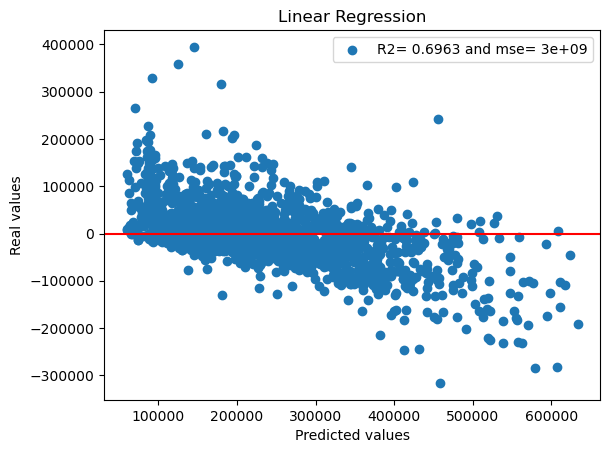

In [112]:
model_test(line_regression_model, 'Linear Regression', X_test, y_test)

In [113]:
model_top_deviation(line_regression_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,...,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Price,Price_test,SD
23,1,47.347305,23,2,0,475,0,7,9.0,35.936615,...,0.014073,1.0,1977,2,100961.810824,159850.800729,171,103147.175713,571069.052600,467921.876887
2299,5,275.645294,86,31,3,7010,7,12,37.0,233.949310,...,0.161976,26.0,2011,3,382784.978700,410431.605679,5,698121.367089,264213.558631,433907.808459
1918,1,46.869541,1,1,0,264,1,16,24.0,35.936615,...,0.007122,1.0,1977,2,147454.605358,159850.800729,186,160693.947654,594565.299770,433871.352115
2439,1,39.709106,6,5,0,1564,0,10,25.0,1.836365,...,0.243205,1.0,2017,3,135294.171631,159850.800729,156,137904.897844,556931.539960,419026.642115
2094,4,98.385445,69,33,1,6783,9,14,22.0,76.081772,...,0.000991,9.0,1979,4,500774.140094,383251.100956,8,496888.902669,91775.321076,405113.581593
350,3,126.621361,24,50,2,12238,3,22,48.0,62.455482,...,0.111627,12.0,2011,3,361843.237465,289337.962452,12,495751.409771,100226.363761,395525.046009
1233,1,42.475578,27,4,0,915,0,12,20.0,35.936615,...,0.011654,10.0,1977,2,122710.743033,159850.800729,277,125674.509929,514137.338771,388462.828843
1957,5,117.855972,169,18,1,3594,5,12,14.0,76.561317,...,0.178917,9.0,2001,1,608674.130507,410431.605679,7,614390.936671,226513.889964,387877.046707
511,1,43.613430,6,5,0,1564,0,3,17.0,3.668460,...,0.243205,1.0,2016,3,135294.171631,159850.800729,156,131961.720079,518952.667244,386990.947165
1298,3,66.674217,137,23,2,3975,0,8,10.0,43.174759,...,0.200147,9.0,1954,0,475467.493485,289337.962452,3,447917.864874,91325.366235,356592.498638


### Случайный лес

In [114]:
random_forest_regressor_model = RandomForestRegressor()
random_forest_regressor_model.fit(X_train, y_train)

RandomForestRegressor()

In [115]:
models_dict['Random Forest Regressor'] = random_forest_regressor_model

#### тестируем

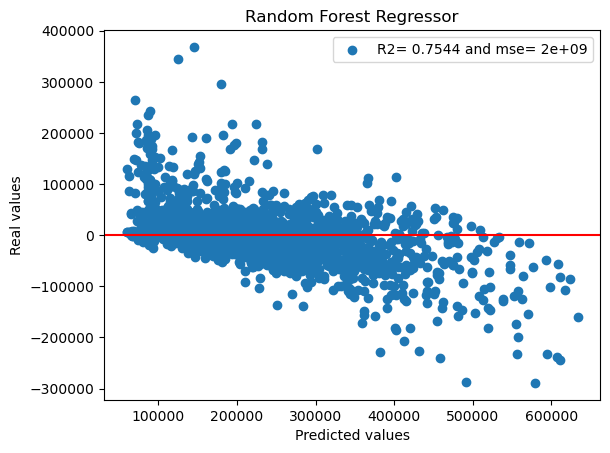

In [116]:
model_test(random_forest_regressor_model,
           'Random Forest Regressor', X_test, y_test)

In [117]:
model_top_deviation(random_forest_regressor_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,...,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Price,Price_test,SD
23,1,47.347305,23,2,0,475,0,7,9.0,35.936615,...,0.014073,1.0,1977,2,100961.810824,159850.800729,171,107599.799756,571069.052600,463469.252844
1918,1,46.869541,1,1,0,264,1,16,24.0,35.936615,...,0.007122,1.0,1977,2,147454.605358,159850.800729,186,154926.709437,594565.299770,439638.590333
2439,1,39.709106,6,5,0,1564,0,10,25.0,1.836365,...,0.243205,1.0,2017,3,135294.171631,159850.800729,156,130082.190178,556931.539960,426849.349782
1233,1,42.475578,27,4,0,915,0,12,20.0,35.936615,...,0.011654,10.0,1977,2,122710.743033,159850.800729,277,116544.349985,514137.338771,397592.988787
2094,4,98.385445,69,33,1,6783,9,14,22.0,76.081772,...,0.000991,9.0,1979,4,500774.140094,383251.100956,8,479963.029188,91775.321076,388187.708111
511,1,43.613430,6,5,0,1564,0,3,17.0,3.668460,...,0.243205,1.0,2016,3,135294.171631,159850.800729,156,133261.049885,518952.667244,385691.617359
350,3,126.621361,24,50,2,12238,3,22,48.0,62.455482,...,0.111627,12.0,2011,3,361843.237465,289337.962452,12,474637.861007,100226.363761,374411.497246
461,3,68.746971,23,0,0,168,0,12,17.0,64.210121,...,0.034656,1.0,2017,3,170912.210083,289337.962452,171,137710.486487,497573.388939,359862.902452
866,1,40.043236,6,5,0,1564,0,3,17.0,40.043236,...,0.243205,1.0,2014,3,135294.171631,159850.800729,156,123766.119368,474624.225504,350858.106136
1659,3,85.887405,17,25,1,5027,1,8,8.0,60.230133,...,0.000000,9.0,1960,0,419768.778587,289337.962452,22,489488.534795,143194.068804,346294.465991


### Градиент бустинг

In [118]:
gradient_boosting_regressor_model = GradientBoostingRegressor()
gradient_boosting_regressor_model.fit(X_train, y_train)

GradientBoostingRegressor()

In [119]:
models_dict['Gradient Boosting Regressor'] = gradient_boosting_regressor_model

#### Тестируем

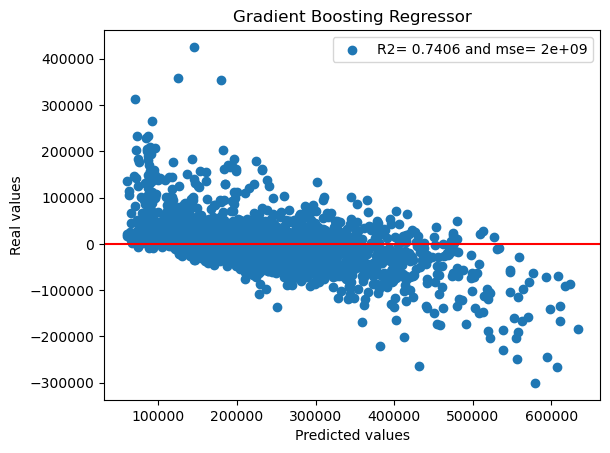

In [120]:
model_test(gradient_boosting_regressor_model,
           'Gradient Boosting Regressor', X_test, y_test)

In [121]:
model_top_deviation(gradient_boosting_regressor_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,...,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Price,Price_test,SD
23,1,47.347305,23,2,0,475,0,7,9.0,35.936615,...,0.014073,1.0,1977,2,100961.810824,159850.800729,171,121733.656618,571069.052600,449335.395982
1918,1,46.869541,1,1,0,264,1,16,24.0,35.936615,...,0.007122,1.0,1977,2,147454.605358,159850.800729,186,148311.298467,594565.299770,446254.001302
350,3,126.621361,24,50,2,12238,3,22,48.0,62.455482,...,0.111627,12.0,2011,3,361843.237465,289337.962452,12,533439.907555,100226.363761,433213.543794
2439,1,39.709106,6,5,0,1564,0,10,25.0,1.836365,...,0.243205,1.0,2017,3,135294.171631,159850.800729,156,129663.330212,556931.539960,427268.209748
2094,4,98.385445,69,33,1,6783,9,14,22.0,76.081772,...,0.000991,9.0,1979,4,500774.140094,383251.100956,8,490493.847605,91775.321076,398718.526529
511,1,43.613430,6,5,0,1564,0,3,17.0,3.668460,...,0.243205,1.0,2016,3,135294.171631,159850.800729,156,124653.317733,518952.667244,394299.349511
1233,1,42.475578,27,4,0,915,0,12,20.0,35.936615,...,0.011654,10.0,1977,2,122710.743033,159850.800729,277,124791.374950,514137.338771,389345.963821
1298,3,66.674217,137,23,2,3975,0,8,10.0,43.174759,...,0.200147,9.0,1954,0,475467.493485,289337.962452,3,461995.152916,91325.366235,370669.786681
866,1,40.043236,6,5,0,1564,0,3,17.0,40.043236,...,0.243205,1.0,2014,3,135294.171631,159850.800729,156,121169.190720,474624.225504,353455.034784
36,4,105.436317,46,31,0,6137,1,23,22.0,68.823044,...,0.188784,10.0,1998,1,375229.664255,383251.100956,35,449026.318041,103510.223601,345516.094439


### Лассо

In [122]:
lasso_cv_model = LassoCV()
lasso_cv_model.fit(X_train, y_train)

LassoCV()

In [123]:
models_dict['LassoCV'] = lasso_cv_model

#### тестируем

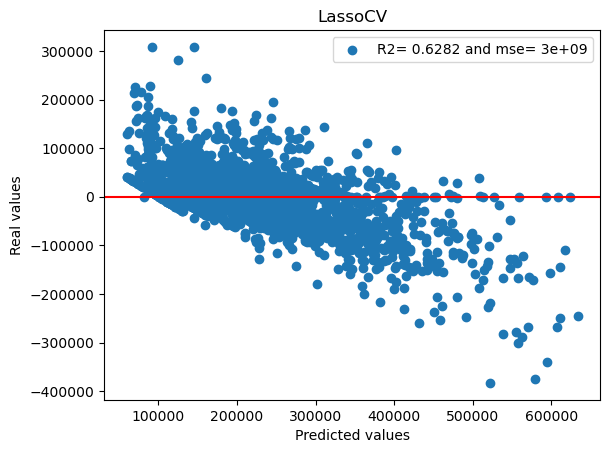

In [124]:
model_test(lasso_cv_model, 'LassoCV', X_test, y_test)

In [125]:
model_top_deviation(lasso_cv_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,...,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Price,Price_test,SD
23,1,47.347305,23,2,0,475,0,7,9.0,35.936615,...,0.014073,1.0,1977,2,100961.810824,159850.800729,171,101303.400464,571069.052600,469765.652136
1918,1,46.869541,1,1,0,264,1,16,24.0,35.936615,...,0.007122,1.0,1977,2,147454.605358,159850.800729,186,147666.443091,594565.299770,446898.856678
2439,1,39.709106,6,5,0,1564,0,10,25.0,1.836365,...,0.243205,1.0,2017,3,135294.171631,159850.800729,156,135539.946655,556931.539960,421391.593305
2094,4,98.385445,69,33,1,6783,9,14,22.0,76.081772,...,0.000991,9.0,1979,4,500774.140094,383251.100956,8,499999.935067,91775.321076,408224.613991
1233,1,42.475578,27,4,0,915,0,12,20.0,35.936615,...,0.011654,10.0,1977,2,122710.743033,159850.800729,277,122991.635840,514137.338771,391145.702932
1298,3,66.674217,137,23,2,3975,0,8,10.0,43.174759,...,0.200147,9.0,1954,0,475467.493485,289337.962452,3,474763.914148,91325.366235,383438.547913
511,1,43.613430,6,5,0,1564,0,3,17.0,3.668460,...,0.243205,1.0,2016,3,135294.171631,159850.800729,156,135539.946655,518952.667244,383412.720589
1957,5,117.855972,169,18,1,3594,5,12,14.0,76.561317,...,0.178917,9.0,2001,1,608674.130507,410431.605679,7,607598.798613,226513.889964,381084.908650
866,1,40.043236,6,5,0,1564,0,3,17.0,40.043236,...,0.243205,1.0,2014,3,135294.171631,159850.800729,156,135539.946655,474624.225504,339084.278849
465,3,120.771217,27,2,0,629,0,8,1.0,118.048981,...,0.072158,1.0,1977,2,214083.587081,289337.962452,277,214109.476916,547434.907016,333325.430100


In [126]:
all_data.loc[all_data['KitchenSquare'] < 3]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2,4765,53,2,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
7,11993,74,2,80.312927,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
8,5172,1,2,64.511436,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
12,6452,13,2,54.522804,31.759752,1.0,8,12.0,1999,0.090799,B,B,74,19083,2,NaN,5,15,B
14,10953,27,1,53.769096,52.408028,1.0,5,4.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14982,12920,23,1,39.610428,38.187572,1.0,6,18.0,2013,0.034656,B,B,0,168,0,NaN,0,0,B
14985,11732,1,1,46.597282,NaN,1.0,17,24.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B
14987,5361,53,3,80.102104,NaN,1.0,13,22.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
14998,4780,62,2,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A


### LGBM регрессор

In [127]:
lgbm_regressor_model = LGBMRegressor()
lgbm_regressor_model.fit(X_train, y_train)

LGBMRegressor()

#### тестируем

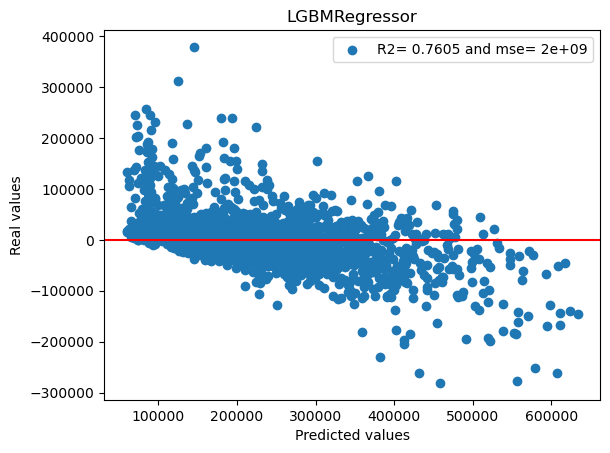

In [128]:
model_test(lgbm_regressor_model, 'LGBMRegressor', X_test, y_test)

In [129]:
model_top_deviation(lgbm_regressor_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,...,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Price,Price_test,SD
23,1,47.347305,23,2,0,475,0,7,9.0,35.936615,...,0.014073,1.0,1977,2,100961.810824,159850.800729,171,115252.418641,571069.052600,455816.633959
1918,1,46.869541,1,1,0,264,1,16,24.0,35.936615,...,0.007122,1.0,1977,2,147454.605358,159850.800729,186,152136.509010,594565.299770,442428.790760
2094,4,98.385445,69,33,1,6783,9,14,22.0,76.081772,...,0.000991,9.0,1979,4,500774.140094,383251.100956,8,520873.172210,91775.321076,429097.851133
2439,1,39.709106,6,5,0,1564,0,10,25.0,1.836365,...,0.243205,1.0,2017,3,135294.171631,159850.800729,156,132130.004850,556931.539960,424801.535109
1233,1,42.475578,27,4,0,915,0,12,20.0,35.936615,...,0.011654,10.0,1977,2,122710.743033,159850.800729,277,118221.165946,514137.338771,395916.172825
511,1,43.613430,6,5,0,1564,0,3,17.0,3.668460,...,0.243205,1.0,2016,3,135294.171631,159850.800729,156,126887.371718,518952.667244,392065.295526
1298,3,66.674217,137,23,2,3975,0,8,10.0,43.174759,...,0.200147,9.0,1954,0,475467.493485,289337.962452,3,470494.104574,91325.366235,379168.738339
461,3,68.746971,23,0,0,168,0,12,17.0,64.210121,...,0.034656,1.0,2017,3,170912.210083,289337.962452,171,143036.557777,497573.388939,354536.831162
866,1,40.043236,6,5,0,1564,0,3,17.0,40.043236,...,0.243205,1.0,2014,3,135294.171631,159850.800729,156,120228.654295,474624.225504,354395.571208
1659,3,85.887405,17,25,1,5027,1,8,8.0,60.230133,...,0.000000,9.0,1960,0,419768.778587,289337.962452,22,497492.355500,143194.068804,354298.286696


#### поправляем

In [130]:
lgbm_regressor_model.get_params

<bound method LGBMModel.get_params of LGBMRegressor()>

In [131]:
np.arange(0.01, 0.05, 0.01)

array([0.01, 0.02, 0.03, 0.04])

In [132]:
parameters = [{
    'max_bin': np.arange(90, 120, 10),
    'n_estimators': np.arange(4000, 7000, 1000),
    'learning_rate': np.arange(0.01, 0.05, 0.01)
}]

In [133]:
clf = GridSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_grid=parameters,
    scoring='neg_mean_squared_error',
    cv=4,
    n_jobs=-1,
)

In [134]:
clf.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid=[{'learning_rate': array([0.01, 0.02, 0.03, 0.04]),
                          'max_bin': array([ 90, 100, 110]),
                          'n_estimators': array([4000, 5000, 6000])}],
             scoring='neg_mean_squared_error')

In [135]:
cv_results = pd.DataFrame(clf.cv_results_)
param_columns = [
    column
    for column in cv_results.columns
    if column.startswith('param_')
]

score_columns = ['mean_test_score']

cv_results = (cv_results[param_columns + score_columns]
              .sort_values(by=score_columns, ascending=False))

cv_results.head(10)

,param_learning_rate,param_max_bin,param_n_estimators,mean_test_score
6,0.01,110,4000,-2.025945e+09
3,0.01,100,4000,-2.045600e+09
7,0.01,110,5000,-2.050298e+09
0,0.01,90,4000,-2.056559e+09
4,0.01,100,5000,-2.066629e+09
8,0.01,110,6000,-2.070852e+09
1,0.01,90,5000,-2.076620e+09
15,0.02,110,4000,-2.087484e+09
5,0.01,100,6000,-2.087922e+09
2,0.01,90,6000,-2.093438e+09


In [136]:
clf.best_params_

{'learning_rate': 0.01, 'max_bin': 110, 'n_estimators': 4000}

#### тестируем

In [137]:
lgbm_regressor_model = LGBMRegressor(
    max_bin=110,
    num_leaves=4,
    n_estimators=4000,
    learning_rate=0.01
)
lgbm_regressor_model.fit(X_train, y_train)

LGBMRegressor(learning_rate=0.01, max_bin=110, n_estimators=4000, num_leaves=4)

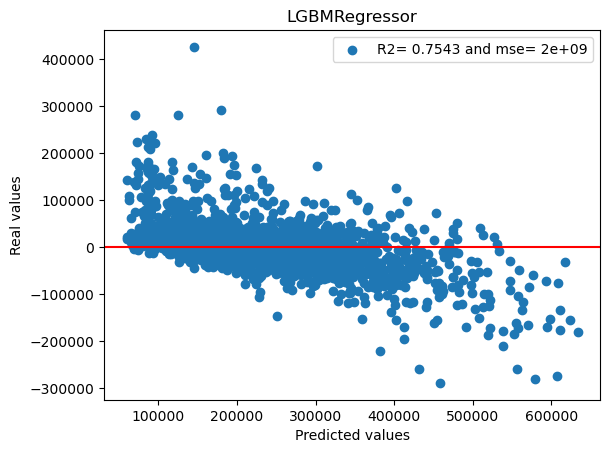

In [138]:
model_test(lgbm_regressor_model, 'LGBMRegressor', X_test, y_test)

In [139]:
models_dict['LGBMRegressor'] = lgbm_regressor_model

### XGB регрессор

In [140]:
xgboost_model = XGBRegressor()
xgboost_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [141]:
models_dict['XGBRegressor'] = xgboost_model

#### тестируем

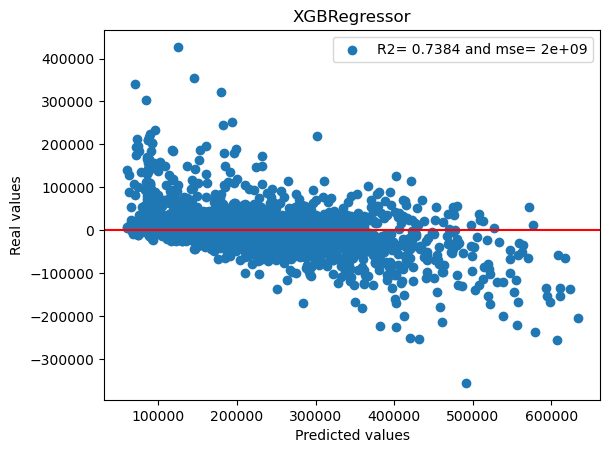

In [142]:
model_test(xgboost_model, 'XGBRegressor', X_test, y_test)

In [143]:
model_top_deviation(xgboost_model, X_test, y_test)

,Rooms,Square,DistrictId,Social_1,Helthcare_2,Social_2,Shops_1,Floor,HouseFloor,LifeSquare,...,Ecology_1,KitchenSquare,HouseYear,cluster_year,mean_price_dr,mean_price_by_rooms,large_district,Price,Price_test,SD
23,1,47.347305,23,2,0,475,0,7,9.0,35.936615,...,0.014073,1.0,1977,2,100961.810824,159850.800729,171,115571.468750,571069.052600,455497.583850
1918,1,46.869541,1,1,0,264,1,16,24.0,35.936615,...,0.007122,1.0,1977,2,147454.605358,159850.800729,186,149062.093750,594565.299770,445503.206020
2439,1,39.709106,6,5,0,1564,0,10,25.0,1.836365,...,0.243205,1.0,2017,3,135294.171631,159850.800729,156,122787.484375,556931.539960,434144.055585
350,3,126.621361,24,50,2,12238,3,22,48.0,62.455482,...,0.111627,12.0,2011,3,361843.237465,289337.962452,12,501777.468750,100226.363761,401551.104989
1233,1,42.475578,27,4,0,915,0,12,20.0,35.936615,...,0.011654,10.0,1977,2,122710.743033,159850.800729,277,121276.984375,514137.338771,392860.354396
511,1,43.613430,6,5,0,1564,0,3,17.0,3.668460,...,0.243205,1.0,2016,3,135294.171631,159850.800729,156,128431.046875,518952.667244,390521.620369
2094,4,98.385445,69,33,1,6783,9,14,22.0,76.081772,...,0.000991,9.0,1979,4,500774.140094,383251.100956,8,480252.406250,91775.321076,388477.085174
1298,3,66.674217,137,23,2,3975,0,8,10.0,43.174759,...,0.200147,9.0,1954,0,475467.493485,289337.962452,3,472724.312500,91325.366235,381398.946265
461,3,68.746971,23,0,0,168,0,12,17.0,64.210121,...,0.034656,1.0,2017,3,170912.210083,289337.962452,171,130549.789062,497573.388939,367023.599877
1544,3,117.237801,2,42,0,9292,3,2,15.0,62.361488,...,0.035145,17.0,2008,1,342699.342039,289337.962452,20,522050.625000,169471.511091,352579.113909


## Результаты

### грузим пакеты

In [144]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

### функции

In [145]:
def models_r2(models, test, valid):
    scores = pd.DataFrame(columns=['name', 'r2', 'mse'])
    for name, model in models.items():
        test_pred = model.predict(test)
        r2 = r2_score(valid, test_pred)
        mse = mean_squared_error(valid, test_pred)
        scores = scores.append(
            {'name': name, 'r2': r2, 'mse': mse}, ignore_index=True)
    scores.sort_values('r2', ascending=False, inplace=True)
    return scores

### Выбираем лучшую модель

In [146]:
models_score_test = models_r2(models_dict, X_test, y_test)
models_score_train = models_r2(models_dict, X_train, y_train)

C:\Users\maxro\AppData\Local\Temp\ipykernel_19140\4277186224.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(
C:\Users\maxro\AppData\Local\Temp\ipykernel_19140\4277186224.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(
C:\Users\maxro\AppData\Local\Temp\ipykernel_19140\4277186224.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(
C:\Users\maxro\AppData\Local\Temp\ipykernel_19140\4277186224.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  scores = scores.append(
C:\Users\maxro\AppData\Local\Temp\ipykernel_19140\4277186224.py:7: FutureWarning: The frame.appe

In [147]:
models_score_test[['name', 'r2']]

,name,r2
1,Random Forest Regressor,0.754367
4,LGBMRegressor,0.754293
2,Gradient Boosting Regressor,0.740596
5,XGBRegressor,0.738379
0,Linear Regression,0.696288
3,LassoCV,0.628189


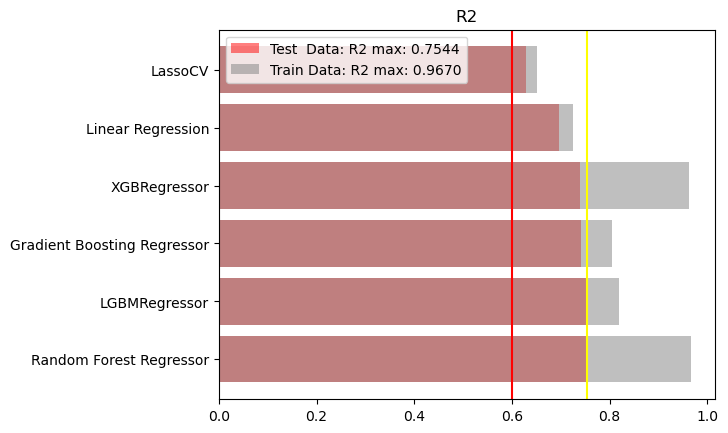

In [148]:
r2_max_test = models_score_test['r2'].max()
r2_max_train = models_score_train['r2'].max()
plt.barh(models_score_test['name'], models_score_test['r2'],
         alpha=0.5, color='red', label=f'Test  Data: R2 max: {r2_max_test:.4f}')
plt.barh(models_score_train['name'], models_score_train['r2'],
         alpha=0.5, color='grey', label=f'Train Data: R2 max: {r2_max_train:.4f}')
plt.title('R2')
plt.legend()
plt.axvline(0.6, color='red')
plt.axvline(r2_max_test, color='yellow')
plt.show()

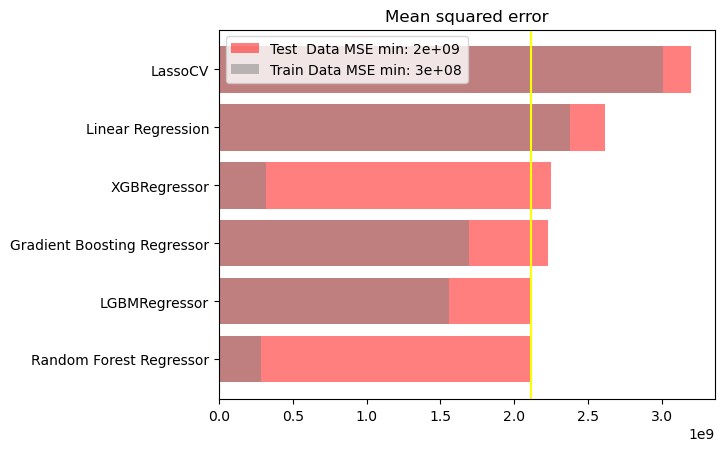

In [149]:
mse_min_test = models_score_test['mse'].min()
mse_min_train = models_score_train['mse'].min()
plt.barh(models_score_test['name'], models_score_test['mse'],
         alpha=0.5, color='red', label=f'Test  Data MSE min: {mse_min_test:.0e}')
plt.barh(models_score_train['name'], models_score_train['mse'],
         alpha=0.5, color='grey', label=f'Train Data MSE min: {mse_min_train:.0e}')
plt.title('Mean squared error')
plt.legend(loc=2)
plt.axvline(mse_min_test, color='yellow')
plt.show()

In [150]:
best_model = models_dict['LGBMRegressor']

In [151]:
pd.DataFrame({'name': list(X_train.columns),
              'importances': list(best_model.feature_importances_)})

,name,importances
0,Rooms,583
1,Square,1616
2,DistrictId,514
3,Social_1,622
4,Helthcare_2,105
5,Social_2,422
6,Shops_1,359
7,Floor,415
8,HouseFloor,780
9,LifeSquare,455


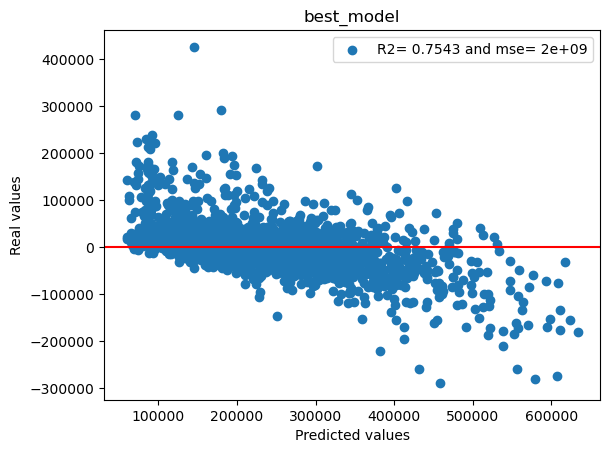

In [152]:
model_test(best_model, 'best_model', X_test, y_test)

## Ответ в файлы

In [153]:
test = data_prepare(test)

In [154]:
test_features = list(X_train.columns)

In [155]:
test[test_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rooms                5000 non-null   uint8  
 1   Square               5000 non-null   float32
 2   DistrictId           5000 non-null   uint8  
 3   Social_1             5000 non-null   uint8  
 4   Helthcare_2          5000 non-null   uint8  
 5   Social_2             5000 non-null   uint16 
 6   Shops_1              5000 non-null   uint8  
 7   Floor                5000 non-null   uint8  
 8   HouseFloor           5000 non-null   float32
 9   LifeSquare           5000 non-null   float32
 10  Social_3             5000 non-null   uint8  
 11  Ecology_1            5000 non-null   float32
 12  KitchenSquare        5000 non-null   float32
 13  HouseYear            5000 non-null   uint16 
 14  cluster_year         5000 non-null   uint8  
 15  mean_price_dr        5000 non-null   f

In [156]:
test['Price'] = best_model.predict(test[test_features])

C:\Users\maxro\AppData\Local\Temp\ipykernel_19140\4231570678.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(price_log, fit=norm)


mu = 215662.41 and sigma = 78147.05


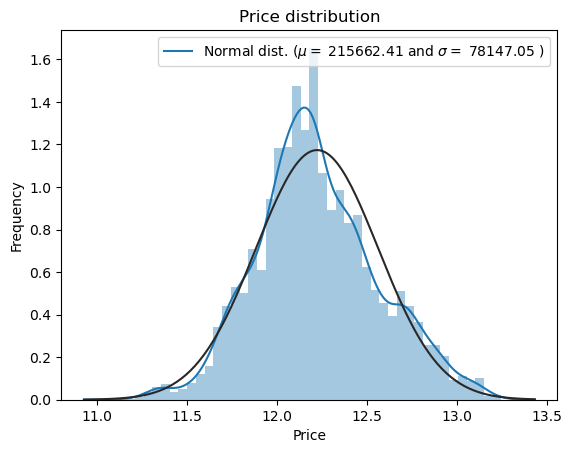

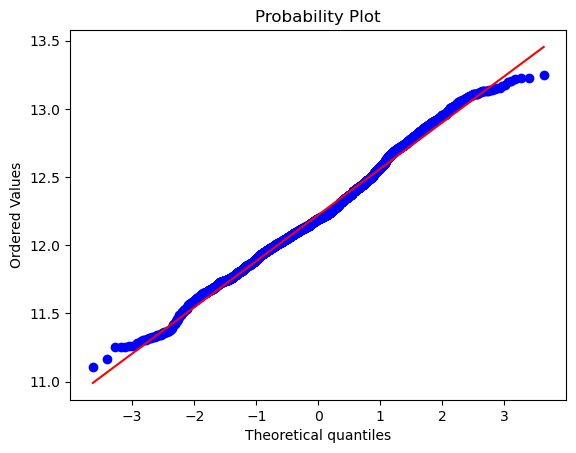

In [157]:
price_log = np.log1p(test['Price'])
sns.distplot(price_log, fit=norm)

mu, sigma = norm.fit(test['Price'])

print(f'mu = {mu:.2f} and sigma = {sigma:.2f}')

plt.legend(
    [f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

# QQ-plot
fig = plt.figure()
res = stats.probplot(price_log, plot=plt)
plt.show()

In [158]:
test[['Id', 'Price']].to_csv('RomashoffPpredictions.csv', index=None)